<p style="font-weight:600; font-size:36px">Model Fitting in Python</p>

<p style="font-weight:400; font-size:24px">J.A. Koch -- 16 Dec 2019</p>



This notebook contains code examples for fitting data, some with complicated implementations. Included are fits to:
1. a functional model with data spanning orders of magnitude (as often seen in rheology)
2. a two-state functional model with two separate data sets
3. a first-order ODE model
4. a second-order ODE model
5. an integral model

Some useful snippets are included at the end.

We import the essential modules in the first cell -- if you borrow things from this document, make sure you include the relevant imports.

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline

# Fit a function spanning orders-of-magnitude:

Given data $(x,y)$, where $y$ spans orders of magnitude, fit a curve $y=f(x)$. Here we use $y=c x^m$ for parameters $m$ and $c$, with $0.1<y<60$.

For data that spans multiple orders of magnitude, a direct curve_fit will gloss over the error for small values since a $\pm$10^-1 error for a $y=$10^-2 data point is treated as 100 times less significant than a $\pm$10 error for a $y=$100 data point. If you trust the small data and find meaning in it, you have to add weight to it. One way is to look at the log10 of the data through the prism of the log10 of the fitting function. Demonstrated here.

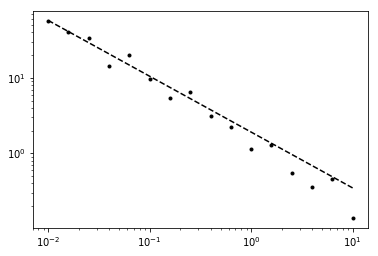

In [18]:
# import numpy as np
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
x=np.array([0.01,0.0158,0.0251,0.0398,0.0631,0.1,0.158,0.251,0.398,0.631,1,1.58,2.51,3.98,6.31,10])
y=np.array([57.09,40.93,33.45,14.20,20.05,9.743,5.424,6.545,3.119,2.258,1.130,1.285,0.5426,0.3565,0.4626,0.1386])

# function
def pwrlaw(x,m,c): #independent variable x, two parameters m & c
    return c*x**m

# direct curve_fit to the (x,y) data set
powV, _ = curve_fit(pwrlaw, x, y) # fitted parameters stored as array powV
# we ignore the second output of this command (which is something like the error tolerance) by using _
m=powV[0]
c=powV[1]

# plotting
plt.loglog(x,y,'k.')
plt.loglog(x,pwrlaw(x,powV[0],powV[1]),'k--')
plt.show()

In the above, the fit as $x\rightarrow 10$ (and $y<3$ish) deviates considerably from the data. This can be alleviated by taking the log10 of the data and using a log10 of the fitting function. One possible implementation, without having to change the definition of the fitting function, uses python's lambda function:

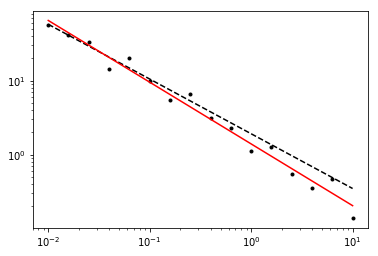

direct fit (dashed) m= -0.74 , c= 1.913
log fit (red) m= -0.834 , c= 1.394


In [19]:
# curve_fit with the log of the data. 
# lambda defines an inline function of variables x,m,c, 
# which we immediately use to call the fitting function pwrlaw(x,m,c)
# through the prism of np.log10, making sure to take np.log10 of the y-data
powV_log, _ = curve_fit(lambda x,m,c: np.log10(pwrlaw(x,m,c)), x, np.log10(y))

m_log=powV_log[0]
c_log=powV_log[1]

#plotting
plt.loglog(x,y,'k.')                     # exp data
plt.loglog(x,pwrlaw(x,m,c),'k--')        # direct fit
plt.loglog(x,pwrlaw(x,m_log,c_log),'r-') # log fit
plt.show()

print("direct fit (dashed)","m=",m.round(decimals=3),", c=",c.round(decimals=3))
print("log fit (red)","m=",m_log.round(decimals=3),", c=",c_log.round(decimals=3))

# Simultaneous fit for model with two states:

Given two data sets $(x_1,y_1)$ and $(x_2,y_2)$, fit $y_1=f(x_1)$ and $y_2=g(x_2)$, where parameters are shared between $f$ and $g$. Here as an example we use a rheological model with two states and four parameters:

* with no vibration: $\tau = G \gamma_\text{c} + \eta_\text{H} \dot{\gamma}.\quad\quad$ 
* with vibration: $\tau = \gamma_\text{c}\frac{G+\eta_\text{H}~f_\text{B}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}+\frac{\eta_\text{H}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}^2$




For a simultaneous fit, we must stitch together the two data sets and create different fitting targets for each half of the 
data.


(I worked with this model a lot in my dissertation: _Hanotin, C., et al. "Viscoelasticity of vibrated granular suspensions." Journal of rheology (2015)._)

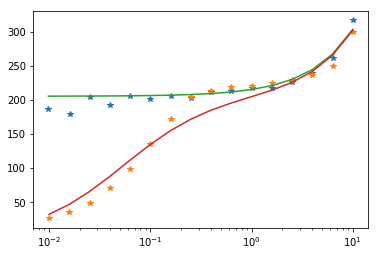

G= 1496.528 , gamma_c= 0.137 , eta_H= 9.792 , f_B= 0.39


In [23]:
# import numpy as np
# from scipy.optimize import least_squares
# import matplotlib.pyplot as plt

# some data
x_v=np.array([9.99991,6.30959,3.98105,2.51174,1.58487,0.99994,0.63104,0.39806,0.25115,0.15849,
              0.09999,0.0631,0.0398,0.02512,0.01585,0.01])
y_v=np.array([300.297,250.444,237.17,229.641,224.519,220.818,218.62,213.132,204.573,172.079,
              135.38,99.5142,71.0392,49.0162,35.9663,26.9438])
x_u=np.array([10.0002,6.30945,3.98143,2.51179,1.58505,0.99994,0.63107,0.3981,0.25121,0.15851,
              0.09994,0.06301,0.03992,0.02517,0.016,0.00986])
y_u=np.array([316.604,260.901,239.982,226.806,218.124,216.893,212.678,211.504,203.419,206.058,
              201.123,205.835,192.87,204.989,179.441,187.024])

# functions for TWO states: unvibrated...
def u(x,G,g,n,f): # independent variable x and four parameters
    return G*g+n*x
# ...and vibrated
def v(x,G,g,n,f):
    return g*(G+n*f)/(x+g*f)*x+n/(x+g*f)*x**2

# Here, the data is not fit to a single function. We instead define different targets for each half
# of the data and then stitch the two sets into a single residual function
def res_two_fxns(pars,xv_a,yv_a,xu_a,yu_a):
    G=pars[0] # G
    gc=pars[1] # \gamma_\text{c}
    nH=pars[2] # \eta_\text{H}
    fB=pars[3] # f_\text{B}

    #vib data
    diff_v=yv_a-v(xv_a,G,gc,nH,fB)
    #unv data
    diff_u=yu_a-u(xu_a,G,gc,nH,fB)

    return np.append(diff_v,diff_u)
    # An array of differences between fit and data at each data point.
    # This is the residuals function that the least squares routine is
    # trying to minimize.

# initial guess for parameters
par_init=np.array([1000.,.2,10.,1.])

# fit occurs through least_squares instead of curve_fit,
result=least_squares(res_two_fxns,par_init,args=(x_v,y_v,x_u,y_u),bounds=(0, np.inf))
# bounds can be used (including with an array for each parameter, e.g. bounds=([0, 0, -10, 1], [1, 1, 1, 3])
# to focus the hunt for optimum, prevent from going negative, etc.

G=result.x[0]
gc=result.x[1]
nH=result.x[2]
fB=result.x[3]


# plotting
plt.semilogx(x_u,y_u,'*')
plt.semilogx(x_v,y_v,'*')
plt.semilogx(x_u,u(x_u,G,gc,nH,fB),'-')
plt.semilogx(x_v,v(x_v,G,gc,nH,fB),'-')
plt.show()

print("G=",G.round(decimals=3),", gamma_c=",gc.round(decimals=3),", eta_H=",nH.round(decimals=3),", f_B=",fB.round(decimals=3))

# Fit a first-order ODE model:

Given data $(t,x)$, fit a first-order ODE: $x'=f(x,t)$. Here we simply fit $y' = -y/\tau$. We could fit to the known analytical solution but will instead demonstrate with an ODE fit, including the fit to the initial condition.

y0= 15.718 , tau= 0.275


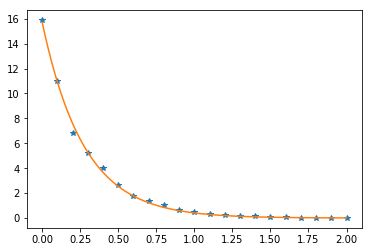

In [22]:
# import numpy as np
# from scipy.integrate import odeint
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
t_data=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])
y_data=np.array([15.88,11.04,6.845,5.232,4.003,2.643,1.790,1.402,1.060,0.6837,0.5205,0.3402,0.2777,
                 0.1704,0.1265,0.09785,0.06003,0.04246,0.03522,0.02437,0.01563])

def s_dot(y,t,tau):
    return -y/tau

def s(t,y0,tau):
    y_fit=odeint(s_dot, y0, t, args=(tau,)) 
    # args expects a duple of parameters, but we only have one, so we have to use the silly looking (tau,)
    return y_fit[:,0]

par,_=curve_fit(s,t_data,y_data,bounds=(0, np.inf))
y0=par[0]
tau=par[1]

print("y0=",y0.round(decimals=3),", tau=",tau.round(decimals=3))
# plotting
t_fit=np.linspace(0,max(t_data),100)
plt.plot(t_data,y_data,'*')
plt.plot(t_fit,s(t_fit,y0,tau),'-')
plt.show()


# Fit a second-order ODE model:

Damped harmonic oscillator: $\ddot{x}+2\zeta \omega_0 \dot{x} + \omega_0^2 x = 0$, including a fit to the initial conditions


y0= 0.1 , yp0= 0.876 , z= 0.217 , w0= 0.922


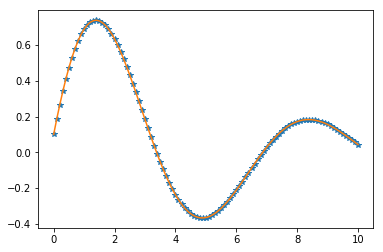

In [5]:
# import numpy as np
# from scipy.integrate import odeint
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
t_data=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,
                 2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4,4.1,4.2,
                 4.3,4.4,4.5,4.6,4.7,4.8,4.9,5,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6,6.1,6.2,6.3,
                 6.4,6.5,6.6,6.7,6.8,6.9,7,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8,8.1,8.2,8.3,8.4,
                 8.5,8.6,8.7,8.8,8.9,9,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10])
y_data=np.array([0.099833417,0.185119238,0.265519589,0.340556589,0.409815754,0.472946963,0.529664842,
                 0.579748609,0.623041378,0.659448956,0.688938173,0.711534766,0.72732085,0.736432029,
                 0.739054168,0.735419872,0.725804719,0.710523283,0.689924979,0.664389793,0.634323918,
                 0.600155344,0.562329439,0.521304561,0.47754773,0.431530402,0.383724369,0.334597816,
                 0.284611566,0.234215532,0.183845395,0.133919539,0.084836244,0.036971157,-0.009324948,
                 -0.053728114,-0.095942848,-0.135703465,-0.172775133,-0.206954615,-0.238070724,
                 -0.265984495,-0.290589073,-0.311809347,-0.32960133,-0.343951305,-0.354874753,
                 -0.362415078,-0.366642149,-0.367650686,-0.365558491,-0.360504567,-0.352647125,
                 -0.342161516,-0.3292381,-0.314080068,-0.296901252,-0.277923926,-0.257376621,
                 -0.235491981,-0.212504662,-0.188649303,-0.164158566,-0.139261285,-0.114180702,
                 -0.089132835,-0.064324959,-0.039954221,-0.016206401,0.006745193,0.02874068,
                 0.049634407,0.069295606,0.087608899,0.104474655,0.119809205,0.133544905,0.14563008,0.156028822,0.164720674,0.171700192,0.176976405,0.180572169,0.182523434,0.182878436,0.18169681,0.179048646,0.175013497,0.169679346,0.163141541,0.155501715,0.14686669,0.137347387,0.127057739,0.116113627,0.104631839,0.092729057,0.080520895,0.068120978,0.05564007,0.043185267])

def ODE2(Y,t,z,w0): # Y=yp,y = yprime,y # parameters z and w0
    yp,y = Y
    ypp = -2*z*w0*yp- w0**2*y 
    return [ypp,yp]

def fit_ODE(t,yp0,y0,z,w0):
    Y0=[yp0,y0]
    y_fit=odeint(ODE2, Y0, t, args=(z,w0))
    return y_fit[:,1]

par,_=curve_fit(fit_ODE,t_data,y_data,bounds=(0, np.inf))


yp0=par[0]
y0=par[1]
z=par[2]
w0=par[3]

print("y0=",y0.round(decimals=3),", yp0=",yp0.round(decimals=3),", z=",z.round(decimals=3),", w0=",w0.round(decimals=3))
# plotting
t_fit=np.linspace(0,max(t_data),100)
plt.plot(t_data,y_data,'*')
plt.plot(t_fit,fit_ODE(t_fit,yp0,y0,z,w0),'-')
plt.show()

# Model with integral

Given data $(x_1,y_1)$ and $(x_2,y_2)$, fit $y_1=\int_{a}^{b}H_1(x_1,t)dt$ and $y_2=\int_{c}^{d}H_2(x_2,t)dt$, where parameters are shared between $H_1$ and $H_2$. Here we fit $G'(\omega)$ and $G''(\omega)$ data to a continuous Maxwell model with
three fitting parameters: $(A,\sigma,\tau)$. The model (I believe from Tschoegl) looks like:

* $G'(\omega) = \int_{0}^{\infty} A\exp\left[\frac{-1}{2\sigma^2}\left[\log(t)-\log(\tau)\right]^2\right]\frac{(\omega t)^2}{1+(\omega t)^2} dt$
* $G''(\omega) = \int_{0}^{\infty} A\exp\left[\frac{-1}{2 \sigma^2}\left[\log(t)-\log(\tau)\right]^2\right]\frac{\omega t}{1+(\omega t)^2} dt$

We numerically integrate using scipy's ```integrate.quad``` and again define a new residual function to fit over two data sets. Note the following cell takes a few seconds to execute -- we perform a numerical integration at each data point.

A= 80098.0 , sigma= 1.363 , tau= 0.769


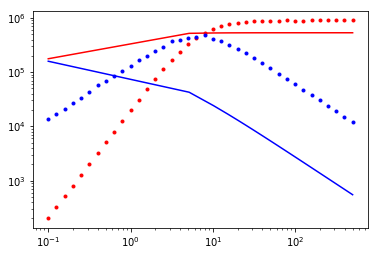

In [16]:
# import numpy as np
# from scipy.integrate import quad
# from scipy.optimize import least_squares
# import matplotlib.pyplot as plt

# some data: oscillation frequency, G', and G''
x=np.array([0.1,0.12589,0.15849,0.19953,0.25119,0.31623,0.39811,0.50119,0.63096,0.79433,1,1.25892,
            1.5849,1.99526,2.51189,3.16229,3.98105,5.01186,6.30957,7.94327,10.0001,12.5892,15.849,
            19.9526,25.1188,31.623,39.8105,50.119,63.0957,79.4327,100,125.892,158.488,199.525,
            251.188,316.226,398.105,499.995])
y1=np.array([202.45445,320.81352,508.37405,805.47595,1275.89108,2020.48246,3198.0499,5058.03912,
             7990.16625,12598.09289,19904.40098,30988.75859,48145.07709,73989.0287,111985.3337,
             165307.1756,236575.3079,329983.2014,425251.392,528045.3188,623080.7574,702890.0275,
             764698.1352,809614.874,840775.7101,891702.6457,875449.8863,884352.743,890063.3753,
             899704.7512,896017.6991,897483.2067,898410.3575,898996.3535,899366.4857,899600.1732,
             899747.6851,899840.0252])
y2=np.array([13496.96318,16989.09192,21084.06417,26912.44251,33862.57634,42595.20942,58553.87365,
             67280.39421,84423.37871,105733.4935,132029.3399,164102.3448,202585.7301,247215.9976,
             296948.6024,378496.7658,396169.0306,432285.5539,449318.9362,493180.4691,415383.0177,
             372218.5299,321659.8882,270512.7399,223146.464,181661.5851,146602.8454,117633.7308,
             94043.74364,75007.29139,59734.51327,47526.62106,37790.8888,30037.88509,23869.67758,
             18965.34279,15067.1755,11997.98698])

# preallocate space for fitting data
f_int1 = np.zeros(len(x))
f_int2 = np.zeros(len(x))

def H1(t,x,a,b,c): # integrand1, for dummy variable t, x, and three parameters a,b,c
    return a*np.exp(-1/(2*b**2)*(np.log(t)-np.log(c))**2)*x**2*t**2/(1+(x*t)**2)

def H2(t,x,a,b,c): # integrand2
    return a*np.exp(-1/(2*b**2)*(np.log(t)-np.log(c))**2)*x*t/(1+(x*t)**2)

def F1(x,a,b,c): # integral1
    for i in np.arange(len(x)):
        f_int1[i], _ = quad(H1,0.,np.inf,args=(x[i],a,b,c))
    return f_int1

def F2(x,a,b,c): # integral2
    for i in np.arange(len(x)):
        f_int2[i], _ = quad(H2,0.,np.inf,args=(x[i],a,b,c))
    return f_int2
    # Running through for loops is very slow, but quad does
    # not accept vector arguments. The data set is hopefully small
    # so that not too much time is wasted in F1 and F2.

def res_two_fxns(pars,x_data,y1_data,y2_data):
    a=pars[0]
    b=pars[1]
    c=pars[2]
    diff1=y1_data-F1(x_data,a,b,c)
    diff2=y2_data-F2(x_data,a,b,c)
    return np.append(diff1,diff2) 


# initial guess for parameters
par_init=np.array([80000.,.2,1.]) # [a,b,c]

result=least_squares(res_two_fxns,par_init,args=(x,y1,y2),bounds=(0, np.inf))

# best fits
a_fit=result.x[0]
b_fit=result.x[1]
c_fit=result.x[2]


#####################
# plot fit equations
def F_fit1(x,a,b,c): # integral1
    f_int_fit1 = np.zeros(len(x))
    for i in np.arange(len(x)):
        f_int_fit1[i] = (quad(H1,0.,np.inf,args=(x[i],a,b,c)))[0]
    return f_int_fit1

def F_fit2(x,a,b,c): # integral2
    f_int_fit2 = np.zeros(len(x))
    for i in np.arange(len(x)):
        f_int_fit2[i] = (quad(H2,0.,np.inf,args=(x[i],a,b,c)))[0]
    return f_int_fit2
# Copied from the above F1,F2,functions. 
# There might be a better way to do this.

x_fit=np.linspace(min(x), max(x),100)

y1_fit=np.zeros(len(x_fit))
y2_fit=np.zeros(len(x_fit))
y1_fit=F_fit1(x_fit,a_fit,b_fit,c_fit)
y2_fit=F_fit2(x_fit,a_fit,b_fit,c_fit)

print("A=",a_fit.round(decimals=0),", sigma=",b_fit.round(decimals=3),", tau=",c_fit.round(decimals=3))
plt.loglog(x,y1,'r.',x_fit,y1_fit,'r-')
plt.loglog(x,y2,'b.',x_fit,y2_fit,'b-')
plt.show()

(The fit above isn't great and might need massaging, for example by choosing a better initial guess or finding a way to include the Jacobian in to ```least_squares```.)

# Additional notes

1. I usually upload data from csv files because that method consistently worked, but you might have success with other filetypes. The following uploads a csv file, located in the current working directory, into a numpy "array" (actually a matrix), with the first column being ```x```-data and the second being ```y```-data.
~~~~
data = np.loadtxt(open("speed_data.csv"),delimiter=',',dtype=np.float)
x=data[:,0]
y=data[:,1]
~~~~
you may additionally find (from the pandas package) a bit of code like
~~~~
import pandas as pd
x=pd.read_clipboard(header=[0,1]) 
t=x.values[:,0]
E=x.values[:,1]
~~~~
to be useful -- it reads in data on your clipboard, e.g. after copying from excel. Here ```header=[0,1]``` refers to the first two rows, which may have labels+units that you wish to ignore.



2. Piecewise functions are probably easiest to define using python lambda functions. Below, the function returns zero until ```x``` reaches a critical value ```Ec```, with $E_c$ potentially being a parameter in the fit.
~~~~
def Fx(x,T,Ec,n):
    y = np.piecewise(x, [x < Ec, x >= Ec], [lambda x:0, lambda x:1./T*((x/Ec)**2.-1.)**n])
    return y
~~~~
3. Sometimes you will have a model with a parameter that you DO NOT want to fit (e.g., if the parameter is a controlled input in the experiment). We can handle this with a lambda function. Below, ```x``` is a function of ```t,a,b,Q```. To avoid fitting ```Q```, we define a new anonymous function inline (i.e., a lambda function) that depends on ```t,a,b``` and not on ```Q```. Then technically curve_fit is performed on the anonymous function, not on the original function ```x```.
~~~~
def x(t,a,b,Q):
    return Q+a*t+b*t**2
Q=2.5
par,_=curve_fit(lambda t,a,b: x(t,a,b,Q),t_data,x_data,bounds=(0, np.inf))
~~~~